# Solution path for the `Wine Quality` data set

The data set can be downloaded from <http://archive.ics.uci.edu/ml/datasets/Wine+Quality>.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer

sys.path.append('../..')
from modules import full_path, path_solver, dual_sorted_L1_norm as dual_norm, pattern

In [2]:
# Import of the data set
wine = pd.read_csv('../datasets/winequality-red.csv', sep=';')
data = wine.drop(columns=['quality'])
target = wine['quality']

In [3]:
# Setting (and data standardization)
X = data.to_numpy(dtype=float)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0, ddof=0)
X = (X - X_mean) / X_std

y = target.to_numpy(dtype=float)
y_mean = y.mean()
y = y - y_mean

# Lambda = np.linspace(4,1,X.shape[-1],dtype=float)
Lambda = np.sqrt(range(1,12))-np.sqrt(range(0,11))

In [4]:
# Numba compilation
_ = full_path(X, y , Lambda, ratio=0., k_max=0., rtol_pattern=1e-6, atol_pattern = 1e-6, rtol_gamma=1e-6, split_max=1e1, log=0)
_ = path_solver(X, y, Lambda, k_max=0., rtol_pattern=1e-6, atol_pattern = 1e-6, rtol_gamma=1e-6, split_max=1e1, log=0)

In [5]:
# Full path
Gamma, Sol, Primal, Gap, M, Split, T = full_path(X, y , Lambda, ratio=1., k_max=1e4, rtol_pattern=1e-10, atol_pattern = 1e-10, rtol_gamma=1e-10, split_max=1e1, log=1)

node 0: gamma = 898.291, elapsed time = 9.51e-05s, gap = 0.00e+00
node 1: gamma = 850.633, elapsed time = 5.26e-03s, gap = 4.55e-13
node 2: gamma = 834.176, elapsed time = 7.22e-03s, gap = 4.55e-13
node 3: gamma = 518.014, elapsed time = 7.92e-03s, gap = 3.98e-13
node 4: gamma = 503.663, elapsed time = 8.41e-03s, gap = 3.98e-13
node 5: gamma = 490.715, elapsed time = 8.95e-03s, gap = 5.12e-13
node 6: gamma = 393.072, elapsed time = 9.42e-03s, gap = 6.25e-13
node 7: gamma = 342.330, elapsed time = 9.72e-03s, gap = 7.39e-13
node 8: gamma = 331.802, elapsed time = 1.00e-02s, gap = 8.53e-13
node 9: gamma = 321.273, elapsed time = 1.04e-02s, gap = 7.96e-13
node 10: gamma = 269.699, elapsed time = 1.07e-02s, gap = 1.71e-13
node 11: gamma = 253.852, elapsed time = 1.10e-02s, gap = 8.53e-13
node 12: gamma = 241.336, elapsed time = 1.14e-02s, gap = 1.14e-13
node 13: gamma = 193.852, elapsed time = 1.18e-02s, gap = 2.27e-13
node 14: gamma = 184.583, elapsed time = 1.22e-02s, gap = 2.27e-13
node 

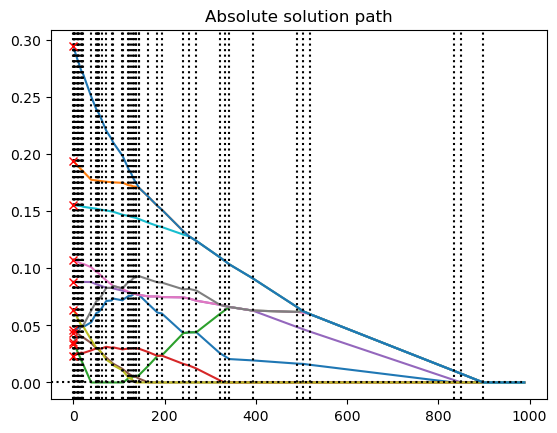

In [6]:
# Absolute solution path + ols
abs_Sol = [np.abs(sol) for sol in Sol]

ols = np.linalg.solve(X.T@X, X.T@y)
abs_ols = np.abs(ols)
    
fig, ax = plt.subplots()
ax.plot([1.1*Gamma[0]] + Gamma, [Sol[0]] + abs_Sol)
for gamma in Gamma:
    ax.axvline(gamma, color='k', linestyle=':')
ax.axhline(0, color='k', linestyle=':', xmax=0.95)
ax.plot(0, [np.abs(ols)], 'rx')
# ax.set_xscale('symlog')
ax.set_title('Absolute solution path')
plt.show() 

In [7]:
fig.savefig('../results/wine-quality_path', bbox_inches="tight", pad_inches=0.05)

In [8]:
# Solver 
frac = 0.5; gamma = frac*dual_norm(X.T@y, Lambda)
t_start = timer()
sol, (primal, gap), k = path_solver(X, y , gamma*Lambda, k_max=1e3, rtol_pattern=1e-10, atol_pattern = 1e-10, rtol_gamma=1e-10, split_max=1e1, log=0)
print(f'pattern for {frac} x gamma_max: {pattern(sol, tol=1e-10)}')
print(f'elapsed time = {timer() - t_start:.2e}s, crossed nodes = {k}, primal-dual gap = {gap:.2e}')

pattern for 0.5 x gamma_max: [ 1 -4  3  0 -2  0 -3 -3  0  4  4]
elapsed time = 1.95e-03s, crossed nodes = 6, primal-dual gap = 8.53e-13
